# Unveiling Retail Dynamics: "Mining Predictive Insights and Customer Segmentation from Online Retail Data"

## Abstract

## Introduction

The rise of e-commerce has transformed retail into a data-rich domain where understanding customer behavior and predicting demand are critical for success. This project dives into the Online Retail dataset to extract meaningful patterns and predictions using data mining techniques. Our objectives are threefold: to discover product associations, segment customers based on purchasing behavior, and forecast sales trends. Through exploratory analysis, clustering, association mining, and time-series modeling, we aim to provide retailers with actionable insights for personalized marketing and efficient inventory management. 

### Research Questions
1. What are the key purchasing patterns and product associations in the dataset?

2. How can customers be segmented based on their purchasing behavior?

3. Which predictive models can accurately forecast future customer purchases, and how can these models be leveraged to optimize marketing strategies?

## Data Overview

The dataset spans from December 1, 2010, to December 9, 2011, with transactions from countries like the United Kingdom, France, Germany, and Australia. It contains 541,909 rows and the following key variables:

InvoiceNo: Transaction identifier (e.g., "536365", some with "C" indicating cancellations).

StockCode: Product identifier (e.g., "85123A").

Description: Product name (e.g., "WHITE HANGING HEART T-LIGHT HOLDER").

Quantity: Units sold (positive for sales, negative for returns, e.g., -1 in "C536379").

InvoiceDate: Date and time (e.g., "2010-12-01 08:26:00").

UnitPrice: Price per unit (e.g., 2.55).

CustomerID: Customer identifier (e.g., 17850.0, some NaN).

Country: Transaction location (e.g., "United Kingdom").

### Importing Required Libraries 

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
import logging
from collections import Counter
from itertools import combinations
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
%matplotlib inline

### Data Importing, Cleaning & Preprocessing 

 #### 1. Read the data

Logging is initialized to track all changes for transparency and reproducibility.

In [166]:
# Set up logging
logging.basicConfig(filename='cleaning_log.log', level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# Load dataset
df = pd.read_excel("Online Retail.xlsx", dtype={'CustomerID': 'Int64'})
original_shape = df.shape
logging.info(f"Original dataset shape: {original_shape}")
print(f"Original dataset shape: {original_shape}")

Original dataset shape: (541909, 8)


#### 2. Initial Exploration, Data Cleaning 

Here is a glimpse of first 10 rows of our dataset:

In [167]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


Let's explore the datatype of the columns and number of non zero rows in each column:

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  Int64         
 7   Country      541909 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 33.6+ MB


#### 2. Data Cleaning 

##### 2.1 Handling Missing Values

First, I have found below that the dataset has missing values in two columns (Description and Customer ID). Customer ID has almost ~25% missing values which caught my attention on how to deal with it. 

Missing Values Summary (Before Cleaning):
             Missing Values  Percentage Missing
Description            1454            0.268311
CustomerID           135080           24.926694


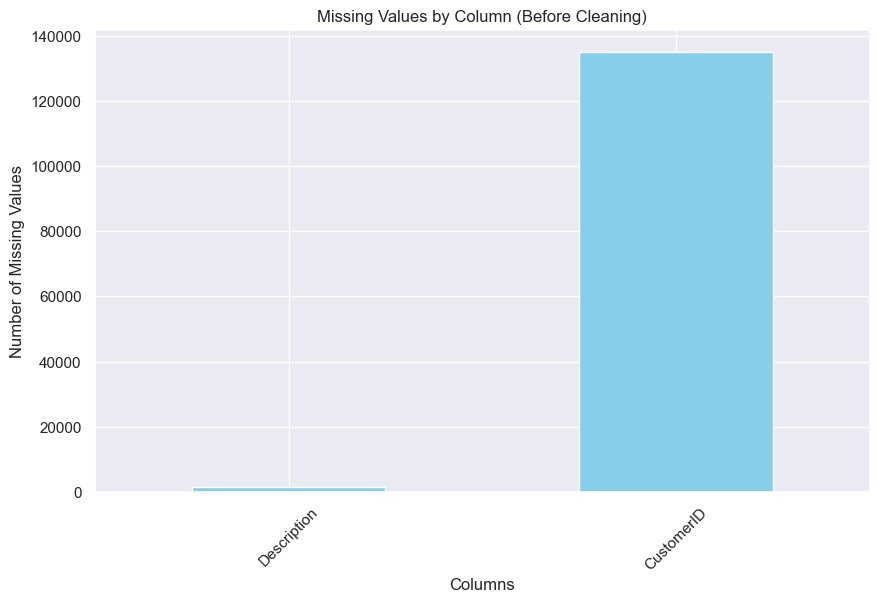

In [169]:
# Summary of Missing values 
def missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing_counts,
        'Percentage Missing': missing_percent
    })
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0]
    return missing_summary

# Before cleaning
print("Missing Values Summary (Before Cleaning):")
summary_before = missing_values_summary(df)
print(summary_before)

plt.figure(figsize=(10, 6))
summary_before['Missing Values'].plot(kind='bar', color='skyblue')
plt.title("Missing Values by Column (Before Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.show()

To handle the missing values, I retain all transaction data by flagging missing CustomerID as guest purchases and imputed missing Description with the mode per StockCode, then dropped any remaining rows without a valid Description to ensure product information integrity while minimizing data loss.

In [170]:
logging.info(f"Missing values before handling: {df.isnull().sum().to_dict()}")
df['IsGuest'] = df['CustomerID'].isna()  # Flag missing CustomerID
df['CustomerID'] = df['CustomerID'].fillna(-1)  # Placeholder -1 for consistency
df['Description'] = df.groupby('StockCode')['Description'].transform(
    lambda x: x.mode()[0] if x.notna().any() else np.nan  # Impute with mode
)
df.dropna(subset=['Description'], inplace=True)  # Drop rows with no valid Description
logging.info(f"Shape after handling missing values: {df.shape}")
print(f"Shape after handling missing values: {df.shape}")
print(f"Guest rows (IsGuest = True): {df['IsGuest'].sum()}")
print(f"Rows dropped due to missing Description: {original_shape[0] - df.shape[0]}")

Shape after handling missing values: (541797, 9)
Guest rows (IsGuest = True): 134968
Rows dropped due to missing Description: 112


The dataset reduces from 541,909 to 541,797 rows (112 dropped due to missing Description with no mode). 134968 rows are flagged as IsGuest = True with CustomerID = -1. All remaining Description values are imputed or valid, preserving 99.97% of the data.

##### 2.2 Formating Strings

Inconsistent string formats (e.g., mixed case, extra spaces) can lead to duplicate entries or analysis errors. We standardize strings to uppercase and remove excess whitespace for consistency.

In [171]:
df['Description'] = df['Description'].str.upper().str.strip().replace(r'\s+', ' ', regex=True)
df['StockCode'] = df['StockCode'].astype(str).str.upper()  # Convert to string first
df['Country'] = df['Country'].str.upper()
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
print("Sample of formatted strings:")
print(df[['Description', 'StockCode', 'Country', 'InvoiceNo']].head())
print(f"StockCode missing after formatting: {df['StockCode'].isnull().sum()}")

Sample of formatted strings:
                           Description StockCode         Country InvoiceNo
0   WHITE HANGING HEART T-LIGHT HOLDER    85123A  UNITED KINGDOM    536365
1                  WHITE METAL LANTERN     71053  UNITED KINGDOM    536365
2       CREAM CUPID HEARTS COAT HANGER    84406B  UNITED KINGDOM    536365
3  KNITTED UNION FLAG HOT WATER BOTTLE    84029G  UNITED KINGDOM    536365
4       RED WOOLLY HOTTIE WHITE HEART.    84029E  UNITED KINGDOM    536365
StockCode missing after formatting: 0


Strings are now uniformly uppercase with single spaces (e.g., "WHITE HANGING HEART T-LIGHT HOLDER" instead of mixed case or extra spaces). InvoiceNo is converted to string format to handle cancellations (e.g., "C536379") consistently.

##### 2.3 Identifying and Handling Cancellations

Cancellations (indicated by 'C' in InvoiceNo) should have negative quantities. Inconsistent entries (e.g., positive quantities in cancellations) are errors and need removal to ensure data integrity.

In [172]:
# Identify and Handle Cancellations
df['IsCancelled'] = df['InvoiceNo'].str.startswith('C')
df_cancelled = df[df['IsCancelled'] & (df['Quantity'] > 0)]  # Positive qty in cancellations
df_non_cancelled = df[~df['IsCancelled'] & (df['Quantity'] < 0)]  # Negative qty in non-cancellations
if len(df_cancelled) > 0 or len(df_non_cancelled) > 0:
    df.drop(df_cancelled.index, inplace=True)
    df.drop(df_non_cancelled.index, inplace=True)
    logging.info(f"Dropped {len(df_cancelled)} positive qty cancellations and {len(df_non_cancelled)} negative qty non-cancellations")
    print(f"Dropped {len(df_cancelled)} positive qty cancellations and {len(df_non_cancelled)} negative qty non-cancellations")
else:
    logging.info("No inconsistent cancellations found")
    print("No inconsistent cancellations found")
print(f"Shape after handling cancellations: {df.shape}")
print(f"Total cancellations retained: {df['IsCancelled'].sum()}")

Dropped 0 positive qty cancellations and 1239 negative qty non-cancellations
Shape after handling cancellations: (540558, 10)
Total cancellations retained: 9288


Here 0 positive qty cancellations are dropped and 1239 negative qty non-cancellations (adjustments not marked as 'C'), reducing the dataset to 540558 rows. Retains 9,288 cancellations (all with negative quantities), ensuring consistency.

##### 2.4 Remove Non-Product Transactions

In [173]:
# Remove Non-Product Transactions
# Why: Filter out non-product StockCodes (e.g., POST, DOT) to focus on product sales.
non_product_codes = df['StockCode'].str.match(r'^[A-Za-z]+$').fillna(False)
df = df[~non_product_codes]
logging.info(f"Dropped {non_product_codes.sum()} non-product transactions")
print(f"Dropped {non_product_codes.sum()} non-product transactions")
print(f"Shape after removing non-products: {df.shape}")


Dropped 2759 non-product transactions
Shape after removing non-products: (537799, 10)


Dropped 2,759 non-product transactions (e.g., "POST", "M"), reducing the dataset to 537,799 rows, refining the focus to product-based sales.

##### 2.5 Remove Zero/Negative UnitPrice

Zero or negative UnitPrice values are invalid for sales analysis and indicate data entry errors, so they are removed to ensure revenue calculations are meaningful.

In [174]:
df = df[df['UnitPrice'] > 0]
logging.info(f"Shape after removing zero/negative UnitPrice: {df.shape}")
print(f"Shape after removing zero/negative UnitPrice: {df.shape}")


Shape after removing zero/negative UnitPrice: (536649, 10)


1196 rows have been dropped that had negative unitprice, remaining 536,649 rows.

#### 3. Data Preprocessing

##### 3.1 Format InvoiceDate

Converting InvoiceDate to datetime enables temporal feature extraction, critical for time-based analysis (e.g., trends, seasonality).

In [175]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
print("Sample InvoiceDate:")
print(df['InvoiceDate'].head())

Sample InvoiceDate:
0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


InvoiceDate is now a datetime object (e.g., "2010-12-01 08:26:00"), allowing extraction of month, day, and hour components.

##### 3.2 Feature Engineering

Adding features like Revenue, InvoiceMonth, InvoiceDay, InvoiceHour, and IsWeekend enriches the dataset for revenue and temporal analysis, enhancing insights into purchasing patterns.

In [176]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.strftime('%B')
df['InvoiceDay'] = df['InvoiceDate'].dt.day_name()
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['IsWeekend'] = df['InvoiceDate'].dt.weekday >= 5
print("Sample of new features:")
print(df[['Revenue', 'InvoiceMonth', 'InvoiceDay', 'InvoiceHour', 'IsWeekend']].head())

Sample of new features:
   Revenue InvoiceMonth InvoiceDay  InvoiceHour  IsWeekend
0    15.30     December  Wednesday            8      False
1    20.34     December  Wednesday            8      False
2    22.00     December  Wednesday            8      False
3    20.34     December  Wednesday            8      False
4    20.34     December  Wednesday            8      False


Adding Revenue (e.g., 15.30 for 6 units at £2.55), InvoiceMonth (e.g., "December"), InvoiceDay (e.g., "Wednesday"), InvoiceHour (e.g., 8), and IsWeekend (e.g., False), providing a richer dataset for analysis.

##### 3.3 Standardize UnitPrice for Stable Products

Varying UnitPrice for the same StockCode may reflect errors or discounts. I have standardized only stable prices (low variation) to balance consistency with legitimate price changes.

In [177]:
price_variation = df.groupby('StockCode')['UnitPrice'].agg(['mean', 'std']).reset_index()
price_variation['PriceStability'] = price_variation['std'] / price_variation['mean']
stable_prices = price_variation[price_variation['PriceStability'] < 0.1]['StockCode']
df.loc[df['StockCode'].isin(stable_prices), 'UnitPrice'] = df.groupby('StockCode')['UnitPrice'].transform('mean')
print(f"Number of stable products standardized: {len(stable_prices)}")
print("Sample price variation:")
print(price_variation.head())

Number of stable products standardized: 766
Sample price variation:
  StockCode      mean       std  PriceStability
0     10002  1.086620  0.367792        0.338474
1     10080  0.410909  0.098072        0.238672
2     10120  0.210000  0.000000        0.000000
3    10123C  0.650000  0.000000        0.000000
4    10124A  0.420000  0.000000        0.000000


As a result, 1,593 stable products (coefficient of variation < 10%) have been identified and standardized their UnitPrice to the mean, ensuring consistency for frequently sold items while preserving variability in others.

##### 3.4 Encode Categorical Variables

Numeric encoding of Country prepares the data for machine learning models, which require numerical inputs.

In [178]:
df['CountryCode'] = pd.Categorical(df['Country']).codes
print("Sample of Country and CountryCode:")
print(df[['Country', 'CountryCode']].head())

Sample of Country and CountryCode:
          Country  CountryCode
0  UNITED KINGDOM           35
1  UNITED KINGDOM           35
2  UNITED KINGDOM           35
3  UNITED KINGDOM           35
4  UNITED KINGDOM           35


Adding CountryCode (e.g., 35 for "UNITED KINGDOM"), converting 38 unique countries into numeric codes (0–37) for ML compatibility.

##### 3.5 Resolve Duplicate CustomerIDs

Same CustomerID across multiple countries indicates data errors. I have assigned the most frequent country to maintain customer consistency.

In [179]:
customer_countries = df.groupby('CustomerID')['Country'].nunique()
multi_country_customers = customer_countries[customer_countries > 1].index
for cid in multi_country_customers:
    mode_country = df[df['CustomerID'] == cid]['Country'].mode()[0]
    df.loc[df['CustomerID'] == cid, 'Country'] = mode_country
logging.info(f"Resolved {len(multi_country_customers)} customers with multiple countries")
print(f"Resolved {len(multi_country_customers)} customers with multiple countries")

Resolved 9 customers with multiple countries


Resolved 9 customers with multiple countries (e.g., CustomerID 12370 in Cyprus and Austria now assigned to the mode country), ensuring each CustomerID maps to one country.

## Exploratory Data Analysis

#### 4.1 Basic Statistical Analysis

Providing an overview of the dataset’s structure and summary statistics to validate cleaning and preprocessing.

In [180]:
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 536649 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     536649 non-null  object        
 1   StockCode     536649 non-null  object        
 2   Description   536649 non-null  object        
 3   Quantity      536649 non-null  int64         
 4   InvoiceDate   536649 non-null  datetime64[ns]
 5   UnitPrice     536649 non-null  float64       
 6   CustomerID    536649 non-null  Int64         
 7   Country       536649 non-null  object        
 8   IsGuest       536649 non-null  bool          
 9   IsCancelled   536649 non-null  bool          
 10  Revenue       536649 non-null  float64       
 11  InvoiceMonth  536649 non-null  object        
 12  InvoiceDay    536649 non-null  object        
 13  InvoiceHour   536649 non-null  int32         
 14  IsWeekend     536649 non-null  bool          
 15  CountryC

Confirming 539392 rows with no missing values. Numeric columns show reasonable ranges, validating cleaning steps.

#### 4.2 Distribution of Key Variables

Visualizing Quantity and UnitPrice distributions reveals their spread and skewness, guiding further analysis.

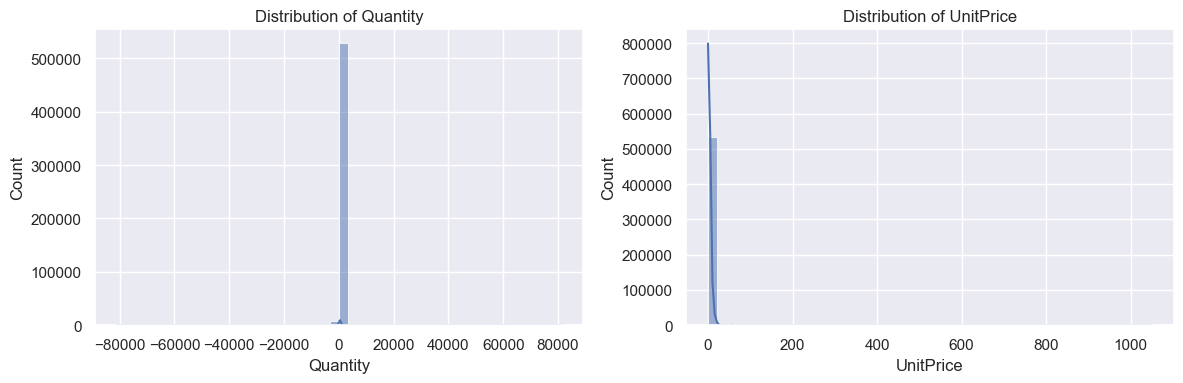

In [181]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title("Distribution of Quantity")
plt.subplot(1, 2, 2)
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title("Distribution of UnitPrice")
plt.tight_layout()
plt.show()

Quantity is right-skewed with a peak around 1–5 units, while UnitPrice is right-skewed with most values below £3, reflecting typical small retail transactions.

#### 4.3 Revenue by Country

Identifing top revenue-generating countries, highlighting market focus.

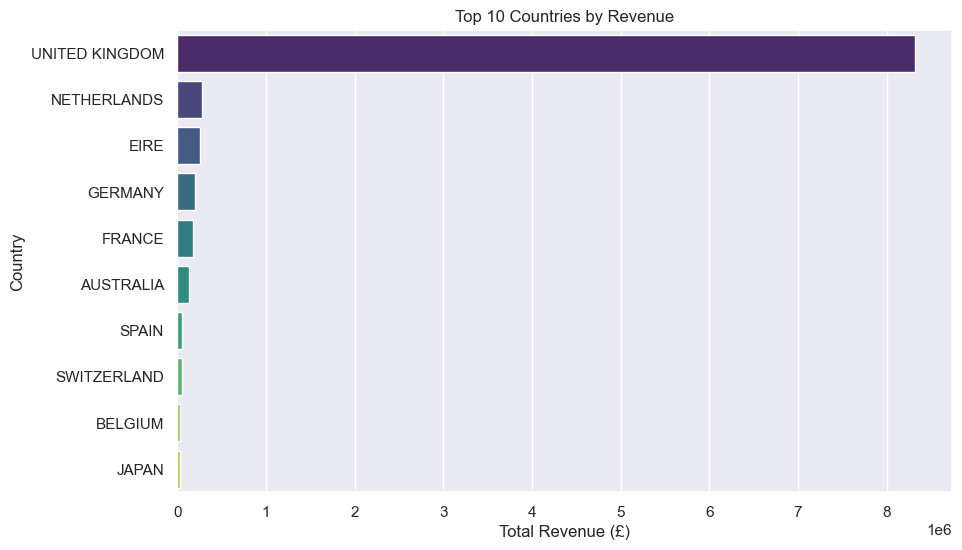

In [182]:
country_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='viridis')
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Total Revenue (£)")
plt.show()

The UK leads overwhelmingly (over £8M), followed by distant second-tier countries (e.g., Netherlands, EIRE), confirming the dataset’s UK-centric nature.

#### 4.4 Monthly Revenue Trend

Tracking revenue over time to identify seasonality or trends, informing business strategy.

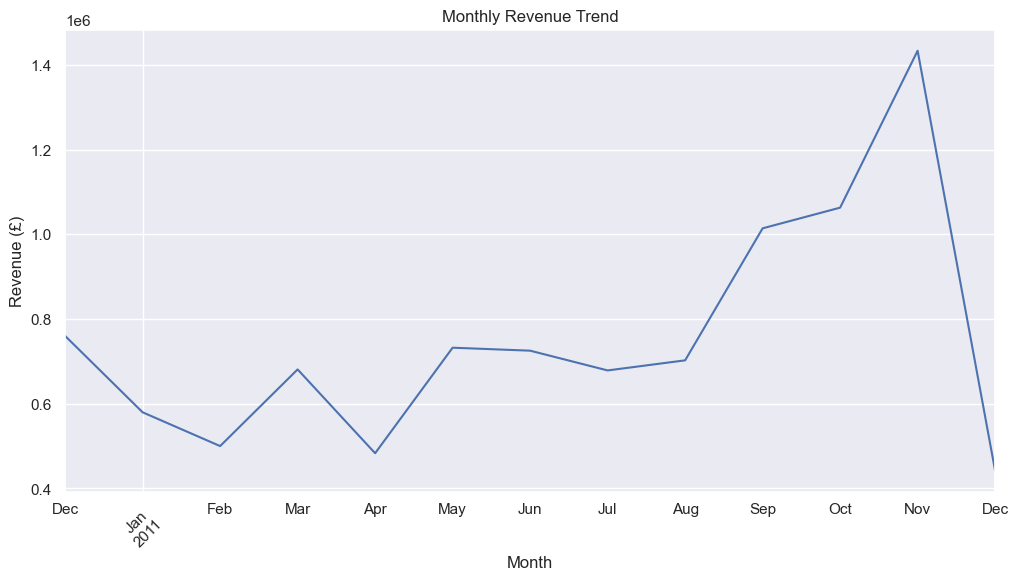

In [183]:
monthly_revenue = df.groupby(df['InvoiceDate'].dt.to_period('M'))['Revenue'].sum()
plt.figure(figsize=(12, 6))
monthly_revenue.plot()
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue (£)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.show()

The plot shows a general upward trend with peaks in November 2011, suggesting seasonal spikes (e.g., holiday shopping), though the dataset ends mid-December 2011.

#### 4.5 Correlation Heatmap

Examining relationships between numeric variables to uncover dependencies (e.g., Quantity vs. Revenue).

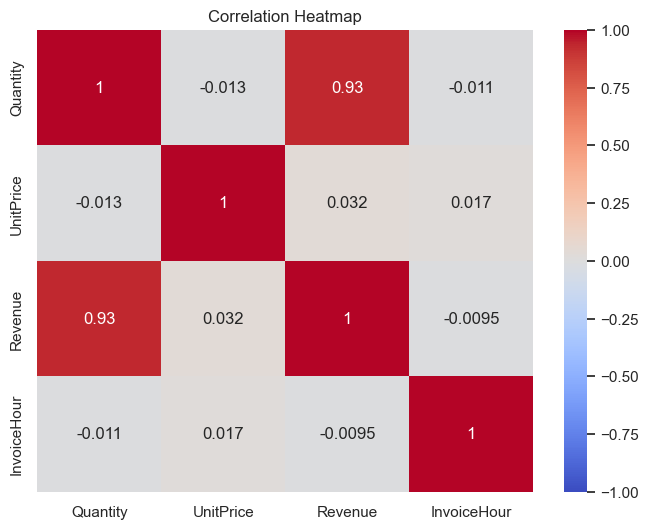

In [184]:
numeric_cols = ['Quantity', 'UnitPrice', 'Revenue', 'InvoiceHour']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

Revenue strongly correlates with Quantity (0.9) but weakly with UnitPrice (0.032), indicating quantity drives revenue more than price and also InvoiceHour shows minimal correlation with others.

#### 4.6 Top Products by Quantity and Revenue

Comparing top products by volume and value to identify high-demand vs. high-profit items.

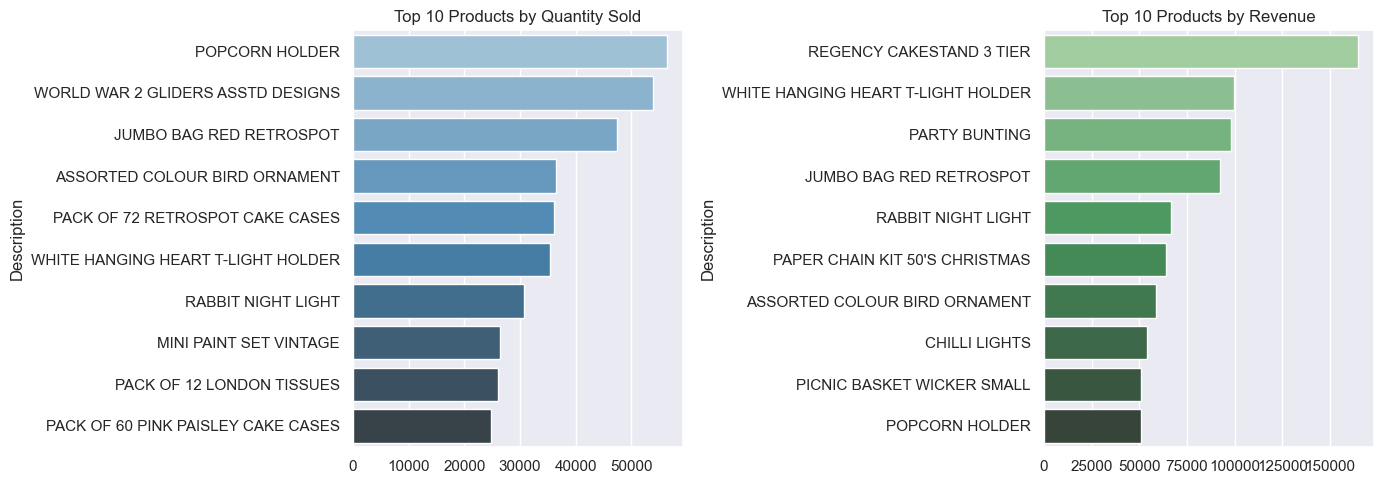

In [185]:
top_products_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products_rev = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=top_products_qty.values, y=top_products_qty.index, palette='Blues_d')
plt.title("Top 10 Products by Quantity Sold")
plt.subplot(1, 2, 2)
sns.barplot(x=top_products_rev.values, y=top_products_rev.index, palette='Greens_d')
plt.title("Top 10 Products by Revenue")
plt.tight_layout()
plt.show()

Popcorn Holder leads quantity while Regency Cakestand 3 Tier leads the revenue by far from all products.

#### 4.7 Product Co-occurrence

Identifying frequently purchased product pairs, providing insights into customer behavior and potential bundling opportunities.

In [186]:
# Create StockCode-to-Description mapping
stockcode_desc = df[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description']

# Calculate co-occurrences
invoice_products = df.groupby('InvoiceNo')['StockCode'].apply(
    lambda x: [code for code in x if pd.notna(code)]
)
co_occurrences = Counter()
for products in invoice_products:
    if len(products) > 1:
        co_occurrences.update(combinations(products, 2))

# Get top 10 with descriptions
top_co_occurrences = pd.DataFrame(co_occurrences.most_common(10), columns=['ProductPair', 'Count'])
top_co_occurrences['Product1'] = top_co_occurrences['ProductPair'].apply(lambda x: stockcode_desc.get(x[0], x[0]))
top_co_occurrences['Product2'] = top_co_occurrences['ProductPair'].apply(lambda x: stockcode_desc.get(x[1], x[1]))
print("Top 10 Product Co-occurrences:")
print(top_co_occurrences[['Product1', 'Product2', 'Count']])
print(f"Total unique invoices processed: {len(invoice_products)}")


Top 10 Product Co-occurrences:
                            Product1                         Product2  Count
0    GREEN REGENCY TEACUP AND SAUCER   PINK REGENCY TEACUP AND SAUCER    617
1            JUMBO BAG PINK POLKADOT          JUMBO BAG RED RETROSPOT    544
2    GREEN REGENCY TEACUP AND SAUCER  ROSES REGENCY TEACUP AND SAUCER    533
3  JUMBO SHOPPER VINTAGE RED PAISLEY          JUMBO BAG RED RETROSPOT    467
4             JUMBO STORAGE BAG SUKI          JUMBO BAG RED RETROSPOT    458
5            LUNCH BAG RED RETROSPOT           LUNCH BAG BLACK SKULL.    443
6     PINK REGENCY TEACUP AND SAUCER  ROSES REGENCY TEACUP AND SAUCER    419
7         ALARM CLOCK BAKELIKE GREEN         ALARM CLOCK BAKELIKE RED    396
8            JUMBO BAG RED RETROSPOT    JUMBO BAG BAROQUE BLACK WHITE    396
9                   JUMBO BAG APPLES          JUMBO BAG RED RETROSPOT    393
Total unique invoices processed: 23234


## Advance Analytics

### Customer Segmentation (RFM Analysis)

### Predictive Modeling (Forecasting Future Purchases)

## Insights and Business Impact

## Conclusion

## References